# Import statements
Following packages are necessary:

In [1]:
import sys
sys.path.append("D:\Julian\workspace\endolas\packages")

import random
from endolas import utils
import os
import imageio
import json
from endolas import closs
from endolas import ccall

from endolas import LASTENSequence

import tensorflow as tf
import numpy as np
import tensorflow.keras.backend as kb
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint

from endolas import UNet
from endolas import preprocess_input as pre_une

from matplotlib import pyplot as plt

# Checks
The version of tensorflow as well as the GPU support are checked.

In [2]:
print(tf.__version__)
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.experimental.get_visible_devices('GPU')

2.1.0


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Functionality
Necessary funcionality is added here

In [3]:
def plot_cube(img, x, y, val):
    
    img[y][x] = val
    img[y][x-1] = val
    img[y][x+1] = val
    img[y-1][x] = val
    img[y-1][x-1] = val
    img[y-1][x+1] = val
    img[y+1][x] = val
    img[y+1][x-1] = val
    img[y+1][x+1] = val  

# 7.7) Supervised Euclidean for LASTEN_10
A U-Net is trained here to predict a displacement field and the euclidean distance is taken as error.

# Data
Import training images

In [6]:
tf.keras.backend.clear_session()

store_path = '../results/7_7_euclidean'

#path_fixed = '/home/julian/Documents/Studium/MT-Masterarbeit/Data/LASTEN_10/fix'
#path_train = '/home/julian/Documents/Studium/MT-Masterarbeit/Data/LASTEN_10/train'
#path_validation = '/home/julian/Documents/Studium/MT-Masterarbeit/Data/LASTEN_10/validation'
#path_test = '/home/julian/Documents/Studium/MT-Masterarbeit/Data/LASTEN_10/test'

path_fixed = r'D:\Julian\data\LASTEN_10\fix'
path_train = r'D:\Julian\data\LASTEN_10\train'
path_validation = r'D:\Julian\data\LASTEN_10\validation'
path_test = r'D:\Julian\data\LASTEN_10\test'

width = 384
height = 384

grid_width = 18
grid_height = 18

# Seeding
Seeds are set to ensure reproducible training.

In [7]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# Network
A U-Net based network is instantiated with keras to run a semantic segmentation.

In [8]:
model = UNet(filters=32, layers=4, activation='linear', classes=2, input_shape=(width, height, 2))

# Training Preparation
Prepare the settings for training the model.

In [9]:
batch_size=4

train_gen = LASTENSequence(path_train,
                           path_fixed,
                           batch_size=batch_size,
                           width=width,
                           height=height,
                           grid_width=grid_width, 
                           grid_height=grid_height,
                           preprocess_input=pre_une,
                           shuffle=True,
                           label="keypoints",
                           channel="moving+fixed")

val_gen = LASTENSequence(path_validation,
                           path_fixed,
                           batch_size=batch_size,
                           width=width,
                           height=height,
                           grid_width=grid_width, 
                           grid_height=grid_height,
                           preprocess_input=pre_une,
                           shuffle=False,
                           label="keypoints",
                           channel="moving+fixed")

logger = CSVLogger(store_path + "/log")
timelogger = ccall.TimeHistory(store_path)
checker = ModelCheckpoint(store_path + "/weights.{epoch:02d}.hdf5", period=10)
checker_best = ModelCheckpoint(store_path + "/best_weights.hdf5", save_best_only=True)
callbacks = [timelogger, logger, checker, checker_best]

eu_loss = closs.EuclideanLoss(batch_size=batch_size, grid_width=grid_width, grid_height=grid_height, loss_type='msed')
eu_met = closs.EuclideanLoss(batch_size=batch_size, grid_width=grid_width, grid_height=grid_height, loss_type='maed')

model.compile(optimizer='adam', loss=eu_loss, metrics=[eu_met])

# Training
Run the training.

In [11]:
model.fit(train_gen,
          epochs=100,
          callbacks=callbacks,
          validation_data=val_gen,
          validation_freq=1,
          #use_multiprocessing=True,
          workers=10,
          max_queue_size=32)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 80 steps, validate for 9 steps
Epoch 1/100


C:\Users\zilkerjn\AppData\Local\Continuum\anaconda3\envs\tf2-gpu\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\zilkerjn\AppData\Local\Continuum\anaconda3\envs\tf2-gpu\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\zilkerjn\AppData\Local\Continuum\anaconda3\envs\tf2-gpu\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown s

80/80 [==============================] - 32s 404ms/step - loss: 2494.0342 - maed: 41.6782 - val_loss: 237963.6319 - val_maed: 447.8174
Epoch 2/100
75/80 [===========================>..] - ETA: 1s - loss: 1801.3941 - maed: 34.7950

KeyError: 'val_loss'

# Evaluation
Evaluate the trained network

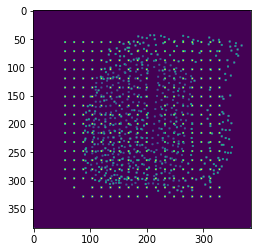

In [12]:
X, y = val_gen[0]

y_pred = model.predict(X)

u_x = y_pred[0,:,:,0]
u_y = y_pred[0,:,:,1]

plt.imshow(y_pred[0,:,:,0], cmap="gray")

plt.imsave(store_path + "/u_x.png", u_x, cmap="gray")
plt.imsave(store_path + "/u_y.png", u_y, cmap="gray")

u_x.dump(store_path + "/u_x")
u_y.dump(store_path + "/u_y")

warp = np.zeros((width, height))

for index in range(0,grid_width*grid_height):
    x_pos = int(y[0, index, 0, 0])
    y_pos = int(y[0, index, 1, 0])
    
    plot_cube(warp, x_pos, y_pos, 1) #blue
    
    ux_field = y_pred[0,:,:,0]
    uy_field = y_pred[0,:,:,1]
    
    ux = ux_field[y_pos][x_pos]
    uy = uy_field[y_pos][x_pos]
    
    x_pos = int(round(x_pos + ux))
    y_pos = int(round(y_pos + uy))
            
    plot_cube(warp, x_pos, y_pos, 2) #green    
    
    x_pos = int(y[0, index, 0, 1])
    y_pos = int(y[0, index, 1, 1])
    
    plot_cube(warp, x_pos, y_pos, 3) #yellow    
    
plt.imshow(warp)
plt.imsave(store_path + "/warp.png", warp)

# 7.8) Supervised Euclidean for LASTEN_25
A U-Net is trained here to predict a displacement field and the euclidean distance is taken as error.

# Data
Import training images

In [19]:
tf.keras.backend.clear_session()

store_path = '../results/7_8_euclidean'

#path_fixed = '/home/julian/Documents/Studium/MT-Masterarbeit/Data/LASTEN_25/fix'
#path_train = '/home/julian/Documents/Studium/MT-Masterarbeit/Data/LASTEN_25/train'
#path_validation = '/home/julian/Documents/Studium/MT-Masterarbeit/Data/LASTEN_25/validation'
#path_test = '/home/julian/Documents/Studium/MT-Masterarbeit/Data/LASTEN_25/test'

path_fixed = r'D:\Julian\data\LASTEN_25\fix'
path_train = r'D:\Julian\data\LASTEN_25\train'
path_validation = r'D:\Julian\data\LASTEN_25\validation'
path_test = r'D:\Julian\data\LASTEN_25\test'

width = 384
height = 384

grid_width = 18
grid_height = 18

# Seeding
Seeds are set to ensure reproducible training.

In [20]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# Network
A U-Net based network is instantiated with keras to run a semantic segmentation.

In [21]:
model = UNet(filters=32, layers=4, activation='linear', classes=2, input_shape=(width, height, 2))

# Training Preparation
Prepare the settings for training the model.

In [22]:
batch_size=4

train_gen = LASTENSequence(path_train,
                           path_fixed,
                           batch_size=batch_size,
                           width=width,
                           height=height,
                           grid_width=grid_width, 
                           grid_height=grid_height,
                           preprocess_input=pre_une,
                           shuffle=True,
                           label="keypoints",
                           channel="moving+fixed")

val_gen = LASTENSequence(path_validation,
                           path_fixed,
                           batch_size=batch_size,
                           width=width,
                           height=height,
                           grid_width=grid_width, 
                           grid_height=grid_height,
                           preprocess_input=pre_une,
                           shuffle=False,
                           label="keypoints",
                           channel="moving+fixed")

logger = CSVLogger(store_path + "/log")
timelogger = ccall.TimeHistory(store_path)
checker = ModelCheckpoint(store_path + "/weights.{epoch:02d}.hdf5", period=10)
checker_best = ModelCheckpoint(store_path + "/best_weights.hdf5", save_best_only=True)
callbacks = [timelogger, logger, checker, checker_best]

eu_loss = closs.EuclideanLoss(batch_size=batch_size, grid_width=grid_width, grid_height=grid_height, loss_type='msed')
eu_met = closs.EuclideanLoss(batch_size=batch_size, grid_width=grid_width, grid_height=grid_height, loss_type='maed')

model.compile(optimizer='adam', loss=eu_loss, metrics=[eu_met])

# Training
Run the training.

In [23]:
model.fit(train_gen,
          epochs=100,
          callbacks=callbacks,
          validation_data=val_gen,
          validation_freq=1,
          #use_multiprocessing=True,
          workers=10,
          max_queue_size=32)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 80 steps, validate for 9 steps
Epoch 1/100


C:\Users\zilkerjn\AppData\Local\Continuum\anaconda3\envs\tf2-gpu\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\zilkerjn\AppData\Local\Continuum\anaconda3\envs\tf2-gpu\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\zilkerjn\AppData\Local\Continuum\anaconda3\envs\tf2-gpu\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown s

50/80 [=================>............] - ETA: 6s - loss: 2382.5966 - maed: 40.9015WARNING:tensorflow:Can save best model only with val_loss available, skipping.


KeyboardInterrupt: 

# Evaluation
Evaluate the trained network

IndexError: index 1181 is out of bounds for axis 0 with size 384

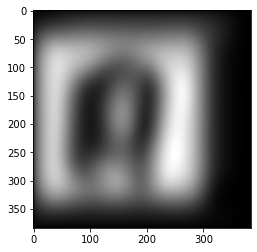

In [24]:
X, y = val_gen[0]

y_pred = model.predict(X)

u_x = y_pred[0,:,:,0]
u_y = y_pred[0,:,:,1]

plt.imshow(y_pred[0,:,:,0], cmap="gray")

plt.imsave(store_path + "/u_x.png", u_x, cmap="gray")
plt.imsave(store_path + "/u_y.png", u_y, cmap="gray")

u_x.dump(store_path + "/u_x")
u_y.dump(store_path + "/u_y")

warp = np.zeros((width, height))

for index in range(0,grid_width*grid_height):
    x_pos = int(y[0, index, 0, 0])
    y_pos = int(y[0, index, 1, 0])
    
    plot_cube(warp, x_pos, y_pos, 1) #blue
    
    ux_field = y_pred[0,:,:,0]
    uy_field = y_pred[0,:,:,1]
    
    ux = ux_field[y_pos][x_pos]
    uy = uy_field[y_pos][x_pos]
    
    x_pos = int(round(x_pos + ux))
    y_pos = int(round(y_pos + uy))
            
    plot_cube(warp, x_pos, y_pos, 2) #green    
    
    x_pos = int(y[0, index, 0, 1])
    y_pos = int(y[0, index, 1, 1])
    
    plot_cube(warp, x_pos, y_pos, 3) #yellow    
    
plt.imshow(warp)
plt.imsave(store_path + "/warp.png", warp)